# Milestone 3: Training a Supervised Image Classifier on the Melanoma Dataset using Transfer Learning

In machine learning, there are no ready-to-use recipes. Certain approaches have been found to work well for certain cases, but in the end, much of it comes down to trial and error. [Occam’s razor](https://en.wikipedia.org/wiki/Occam%27s_razor) (the principle roughly summarized as “the simplest solution is usually the best one”) suggests starting from the most basic method, and building up on top of it until we get the performance we want. Keeping track of improvements we get at each step also helps us justify our efforts!

## Part A: The Data

Here I reuse the Dataset code that I wrote for Milestone 2.

Even in the extreme situation of only having 200 labeled samples available for training, we still have to set aside some number of them for the validation set. The fewer training samples we have, the greater the risk of overfitting, which makes having a validation set absolutely essential. It is up to you to decide what fraction of the precious few labeled samples to keep for validation purposes; I set it at 30% or 60 images, as anything smaller than that would likely result in a major val set overfitting problem.

In [2]:
import os
from os import listdir
from os.path import join

from PIL import Image
import random

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import copy

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import utils, models
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Device: ", device)

from pathlib import Path


Current Device:  cuda


In [3]:

# Define a function to set the seed. This will make results reproducible.
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
            
    # [your code here]

# Define a function to check if a file is actually an image.
def is_image(filename):
    if isinstance(filename, str):
        filename = Path(filename)
    return filename.suffix in ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']


In [4]:
# Some test for Path 

dir_labeled = "./data/MelanomaDetectionLabeled/labeled/"
dir_test  = "./data/MelanomaDetectionLabeled/test/"

Number of image is 200
Label: 0


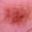

In [5]:

class LabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Optional transform to be applied
                on an image.
        """
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        p = Path(dir_path).resolve()
        self.img_path_list = [f for f in p.iterdir() if is_image(f)]
        self.transform = transform
        
        
    def __len__(self):
        return len(self.img_path_list)    

    def __getitem__(self, idx):
        
        # Here is where the image actually gets read:
        img_path = self.img_path_list[idx]
        # img = read_image(str(img_path)).type(torch.float32)/255.0        
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        label = int(img_path.stem.split('_')[1])

        return img, label
    
    
# test code 

labeled_set = LabeledDataset(dir_labeled)

print('Number of image is {}'.format(len(labeled_set)))
print('Label:', labeled_set[0][1])

labeled_set[0][0]


In [6]:

labeled_set = LabeledDataset(dir_labeled, transform=transforms.ToTensor())
img = labeled_set[0][0]
img




tensor([[[0.8353, 0.8588, 0.8863,  ..., 0.9216, 0.9255, 0.9137],
         [0.8353, 0.8471, 0.8667,  ..., 0.9098, 0.9176, 0.9098],
         [0.8588, 0.8667, 0.8667,  ..., 0.8863, 0.8941, 0.8902],
         ...,
         [0.8000, 0.8039, 0.8118,  ..., 0.7412, 0.7333, 0.7255],
         [0.8078, 0.8000, 0.8000,  ..., 0.7176, 0.7490, 0.7725],
         [0.8196, 0.8078, 0.7961,  ..., 0.7686, 0.8118, 0.8275]],

        [[0.4980, 0.5216, 0.5529,  ..., 0.5608, 0.5647, 0.5529],
         [0.4980, 0.5137, 0.5333,  ..., 0.5529, 0.5608, 0.5529],
         [0.5137, 0.5216, 0.5216,  ..., 0.5294, 0.5373, 0.5333],
         ...,
         [0.4824, 0.4863, 0.4941,  ..., 0.4275, 0.4196, 0.4118],
         [0.5020, 0.4941, 0.4941,  ..., 0.4039, 0.4353, 0.4588],
         [0.5137, 0.5020, 0.4902,  ..., 0.4471, 0.4902, 0.5059]],

        [[0.5961, 0.6196, 0.6431,  ..., 0.6431, 0.6471, 0.6353],
         [0.5961, 0.6039, 0.6235,  ..., 0.6235, 0.6314, 0.6235],
         [0.6078, 0.6157, 0.6078,  ..., 0.5961, 0.6039, 0.

Batch labels tensor([0, 0, 0, 0])


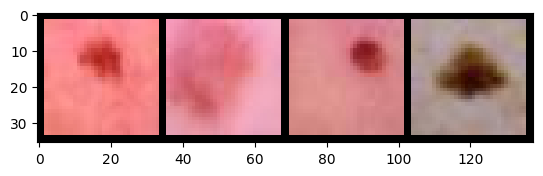

Batch labels tensor([1, 1, 0, 1])


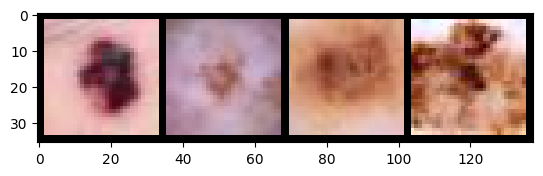

Batch labels tensor([1, 1, 0, 0])


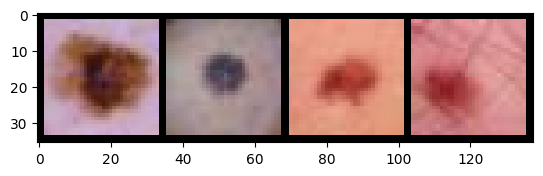

In [7]:
labeled_loader = DataLoader(labeled_set, batch_size=4, shuffle=True)

for batch_idx, batch in enumerate(labeled_loader):    
    if batch_idx > 2:
        break 
    
    print("Batch labels", batch[1].data)
    image_grid = torchvision.utils.make_grid(batch[0], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.pause(0.05)
    
    

In [8]:



# Choose some transformations
rotation = transforms.RandomChoice([transforms.RandomRotation([-3, 3]), 
                                    transforms.RandomRotation([87, 93]), 
                                    transforms.RandomRotation([177,183]),
                                    transforms.RandomRotation([267, 273])])
augmentation = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                   transforms.RandomVerticalFlip(), 
                                   rotation])



# Instantiate the Label Dataset class for training
labeled_set = LabeledDataset(dir_labeled, transform=transforms.Compose([transforms.ToTensor(), augmentation]))


In [9]:

# Randomly split the dataset (don't forget to set the seed!)
set_seed(123)

train_set, val_set = torch.utils.data.random_split(labeled_set, [0.7, 0.3])


In [10]:

# Instantiate the LabeledDataset class for testing
test_set = LabeledDataset(dir_test, transform=transforms.ToTensor())

# Print the number of images in the train, validation and test sets
print("Number of images in the training set: ", len(train_set))
print("Number of images in the validation set: ", len(val_set))
print("Number of images in the test set: ", len(test_set))

# Write data loaders for training, validation and testing
# Since we have so few samples for the fully supervised part, you can use the entire set 
# at each training iteration, rather than separate it into mini-batches:

# [your code here]

Number of images in the training set:  140
Number of images in the validation set:  60
Number of images in the test set:  600


## Part B: Training a Supervised Classifier

### The Model

Pytorch offers many of the common network architectures, as well as pretrained models, via its `torchvision.models` package. Below I use a `resnet18` model, one of the smaller versions of the **residual network** that is often used for image classification, whose outmoust layer I modify in order to fit the binary classification problem at hand:

In [20]:
# Set the device to what's available ('GPU' or 'CPU')
# Already done above
print(device)

!pip install torch_summary 
from torchsummary import summary

# Load a model architecture (e.g. ResNet18)
model = models.resnet18(weights='DEFAULT')
summary(model, input_data=torch.zeros(1, 3, 224, 224))

cuda


TypeError: summary() got an unexpected keyword argument 'input_data'

In [ ]:

'''
Below I replace the original nn.Linear(model.fc.in_features, model.fc.out_features) with two layers,
combined into a single nn.Sequential module: nn.Linear(model.fc.in_features, 1) that is followed by
a Sigmoid layer.
'''
# [your code here]

# Make sure to specify that the network is to be run on the GPU
# [your code here]
    

### The Training

In [13]:
# Choose a loss function
# [your code here]

# Choose an optimizer
# [your code here]

def train(model, device, train_loader, optimizer):
    
    # train() is the mode that "turns on" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    # [your code here]
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # [your code here]
        
    return epoch_loss


def test(model, device, test_loader):
    
    # eval() is the mode that "turns off" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    # [your code here]
    
    with torch.no_grad():
        # [your code here]
    return test_loss, (100. * correct / len(test_loader.dataset)) # test loss, test accuracy

# Keep track of losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Training loop    
for epoch in range(1, num_epochs+1):
    # [your code here]


# Plot the results
# [your code here]

IndentationError: expected an indented block after 'for' statement on line 13 (1465866682.py, line 17)

Surprisingly, despite only having been trained on 140 images, the supervised model gives us a much better result than the trivial baseline of 50%. A visual inspection of the `labeled` and `test` folders suggests a likely answer to the mystery: for whatever reason, many of the images of the melanoma-negative moles come in warmer shades than the malignant samples. The dataset being what it is, can we move past this accidental "feature" and learn something useful about detecting melanomas?

## Part C: Transfer Learning

Using a pretrained ResNet model instead of a randomly-initialized one requires a single change to the previous section: setting the `pretrained` flag to `True`.

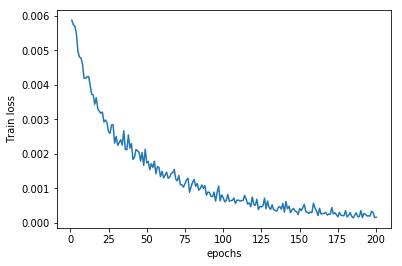

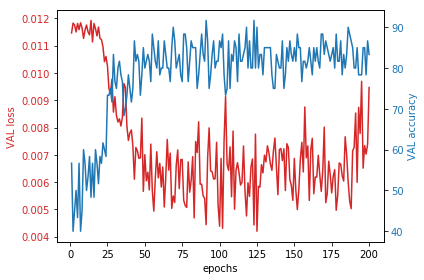

Accuracy on the test set:  75.0


In [ ]:
# Load a pretrained model (e.g. ResNet18)
# [your code here]

# The loss function
# [your code here]

# The optimizer
# [your code here]

# Keep track of losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# The trainign loop    
for epoch in range(1, num_epochs+1):
    # [your code here]

# Plot the results    
# [your code here]

# Load best model weights
# [your code here]

Transfer learning has had enormous success in the field of computer vision. However, it performs best when the data that the model has been pre-trained on comes from a similar distribution as that from the new task. Most of the pre-trained models provided in `torchvision.models` have been trained on images sized 224x224 that come from a natural domain (e.g. [the ImageNet](http://www.image-net.org)). This difference from our 32x32 images of moles is what is behind the small improvement in the final accuracy that we achieve compared to the model that was trained from scratch (Part B above).


